<a href="https://colab.research.google.com/github/juliaviolet/Python_Options/blob/main/Test_Project_06_Computational_Finance_CMM%26PL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Test Project — Computational Finance**

**Complete Market Models & Pricing Library**

Write a pricing library for European plain vanilla and exotic options making use of geometric Brownian motion as the stochastic process. The pricing shall be based on Monte Carlo simulation.

The pricing library shall have:

* a class for the risk-neutral discounting (taking the short rate as parameter, generating discount factors as required, etc.)
* a class to model the parameters of the underyling risk factor and a European option (initial value, volatility, time-to-maturity, dividends, strike price, option type etc.)
* a class to value European **vanilla options** based on Monte Carlo simulation
* a class to value European **lookback options** &mdash; with either fixed or floating strike (see https://en.wikipedia.org/wiki/Lookback_option)
* a class to value European **Asian options** &mdash; with either fixed price or fixed strike (see https://en.wikipedia.org/wiki/Asian_option)

**GBMModel:** This class represents a Geometric Brownian Motion (GBM) model for generating stock price paths. It has an init method that initializes the class with parameters such as initial stock price S0, volatility, sigma, risk-free interest rate r, and time to maturity T. The class also has a generate_price_paths method that takes the number of steps n_steps and generates a simulated stock price path using the GBM formula. The method calculates the price paths by simulating random values (dW) from a normal distribution with mean 0 and standard deviation sqrt(dt), where dt is the time step calculated as T / n_steps. It then calculates the cumulative sum of dW to get W and creates a time array t using linspace with values from dt to T. Finally, it uses the GBM formula to calculate the stock prices S based on the initial price, interest rate, volatility, time, and the random values W. The method returns the generated price paths S.

**EuropeanOption Class:** This class represents a European option and inherits from the GBMModel class. It has an __init__ method that initializes the class with parameters such as the GBM model GBMModel, strike price K, time to maturity T, and option type ('call' or 'put').The class also has a payoff method that calculates the payoff of the option based on the final price in the price path. Inside the payoff method, it checks the option type and returns the maximum of either (S_T - K, 0) for a call option or (K - S_T, 0) for a put option, where S_T is the final price in the price path. Additionally, it has an mc_price method that performs Monte Carlo simulations. It generates n_simulations of price paths using the generate_price_paths method from the GBMModel class. Then, it calculates the payoffs for each path using the payoff method and returns the average price discounted by calling the discount_factor method with the maturity T from the disc object.

**LookbackOption Class:** This class represents a lookback option and inherits from the EuropeanOption class. It has an __init__ method that initializes the class with parameters similar to the EuropeanOption class and an additional parameter fixed_strike indicating whether the strike price is fixed or not. The class overrides the payoff method to calculate the payoff of the lookback option based on the maximum or minimum price in the price path, depending on the option type and the fixed_strike flag. Inside the payoff method, if fixed_strike is True, it checks the option type and returns the maximum of either (max(price_paths) - K, 0) for a call option or (K - min(price_paths), 0) for a put option, where price_paths is an array of price paths. If fixed_strike is False, it returns the maximum of either the difference between the last price in price_paths and the minimum prices in price_paths (for a call option) or the difference between the maximum prices in price_paths and the last price in price_paths (for a put option).

**AsianOption Class:** The __init__ method is the constructor for the AsianOption class. It initializes the object and sets its initial attributes. The super().__init__ line calls the constructor of the EuropeanOption class, passing the necessary parameters. The GBMModel parameter represents an instance of the GBMModel class, K represents the strike price, T represents the time to expiration, option_type represents the type of option (either "call" or "put"), and fixed_strike is a boolean parameter with a default value of True. The
self.fixed_strike attribute is set based on the value of the fixed_strike parameter. The payoff method calculates the payoff of the Asian option based on the provided price_paths. It first calculates the average price (S_avg) across all paths using np.mean(price_paths, axis=0).

Next, it checks the value of self.fixed_strike. If it is True, it checks the option_type and calculates the payoff accordingly. If option_type is 'call', it returns the element-wise maximum of (S_avg - self.K) and 0, using np.maximum(S_avg - self.K, 0). If option_type is 'put', it returns the element-wise maximum of (self.K - S_avg) and 0, using np.maximum(self.K - S_avg, 0).If
self.fixed_strike is False, it performs similar calculations, but using the final price in the price_paths array (price_paths[-1, :]) instead of the strike price.

In [1]:
import numpy as np

class GBMModel:
    def __init__(self, S0, sigma, r, T):
        self.S0 = S0
        self.sigma = sigma
        self.r = r
        self.T = T

    def generate_price_paths(self, n_steps, n_paths):
        dt = self.T / n_steps
        dW = np.random.normal(0, np.sqrt(dt), (n_steps, n_paths))
        W = np.cumsum(dW, axis=0)
        t = np.linspace(dt, self.T, n_steps)[:, None]
        S = self.S0 * np.exp((self.r - 0.5 * self.sigma ** 2) * t + self.sigma * W)
        return S

class EuropeanOption:
    def __init__(self, GBMModel, K, T, option_type):
        self.GBMModel = GBMModel
        self.K = K
        self.T = T
        self.option_type = option_type

    def payoff(self, price_paths):
        S_T = price_paths[-1, :]
        if self.option_type == 'call':
            return np.maximum(S_T - self.K, 0)
        elif self.option_type == 'put':
            return np.maximum(self.K - S_T, 0)
        else:
            raise ValueError('Option type must be either "call" or "put".')

    def mc_price(self, n_simulations, n_steps, disc):
        price_paths = self.GBMModel.generate_price_paths(n_steps, n_simulations)
        payoffs = self.payoff(price_paths)
        price = np.mean(payoffs) * disc.discount_factor(self.T)
        return price

class LookbackOption(EuropeanOption):
    def __init__(self, GBMModel, K, T, option_type, fixed_strike=True):
        super().__init__(GBMModel, K, T, option_type)
        self.fixed_strike = fixed_strike

    def payoff(self, price_paths):
        if self.fixed_strike:
            if self.option_type == 'call':
                return np.maximum(np.max(price_paths, axis=0) - self.K, 0)
            elif self.option_type == 'put':
                return np.maximum(self.K - np.min(price_paths, axis=0), 0)
        else:
            if self.option_type == 'call':
                return np.maximum(price_paths[-1, :] - np.min(price_paths, axis=0), 0)
            elif self.option_type == 'put':
                return np.maximum(np.max(price_paths, axis=0) - price_paths[-1, :], 0)

class AsianOption(EuropeanOption):
    def __init__(self, GBMModel, K, T, option_type, fixed_strike=True):
        super().__init__(GBMModel, K, T, option_type)
        self.fixed_strike = fixed_strike

    def payoff(self, price_paths):
        S_avg = np.mean(price_paths, axis=0)
        if self.fixed_strike:
            if self.option_type == 'call':
                return np.maximum(S_avg - self.K, 0)
            elif self.option_type == 'put':
                return np.maximum(self.K - S_avg, 0)
        else:
            if self.option_type == 'call':
                return np.maximum(price_paths[-1, :] - S_avg, 0)
            elif self.option_type == 'put':
                return np.maximum(S_avg - price_paths[-1, :], 0)

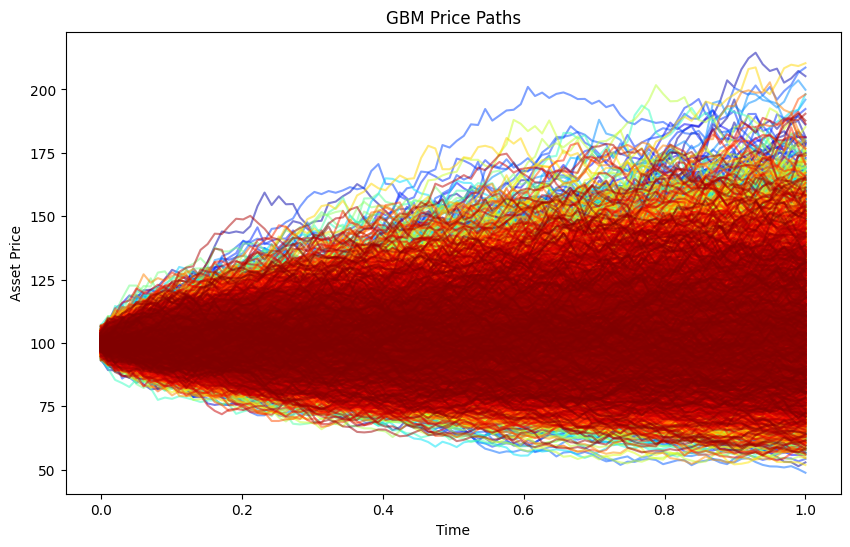

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

class RiskNeutralDiscounting:
    def __init__(self, r):
        self.r = r

    def discount_factor(self, T):
        return np.exp(-self.r * T)

# Initialize GBMModel and RiskNeutralDiscounting
gbm = GBMModel(S0=100, sigma=0.2, r=0.05, T=1)
disc = RiskNeutralDiscounting(r=0.05)

# Generate and plot multiple price paths
n_steps = 100
n_paths = 10000
price_paths = gbm.generate_price_paths(n_steps, n_paths)

# Create a color map
colors = cm.jet(np.linspace(0, 1, n_paths))

plt.figure(figsize=(10, 6))
for i in range(n_paths):
    plt.plot(np.linspace(0, gbm.T, n_steps), price_paths[:, i], color=colors[i], alpha=0.5)
plt.title('GBM Price Paths')
plt.xlabel('Time')
plt.ylabel('Asset Price')
plt.show()

In [ ]:
# Setup the common parameters
S0 = 10
K = 11
r = 0.01
T = 1
vol = 0.2

# Create a discount object
disc = RiskNeutralDiscounting(r)

# Create a GBM model object
model = GBMModel(S0, vol, r, T)

# Setup simulation parameters
n_simulations = 10000
n_steps = 100

In [ ]:
# Create a European call option object
option_eu = EuropeanOption(model, K, T, 'call')
# Calculate the price
price_eu = option_eu.mc_price(n_simulations, n_steps, disc)
print(f"European Call Option: {price_eu:.2f}")
# Create a European put option object
option_eu = EuropeanOption(model, K, T, 'put')
# Calculate the price
price_eu = option_eu.mc_price(n_simulations, n_steps, disc)
print(f"European Put Option: {price_eu:.2f}")

European Call Option: 0.46
European Put Option: 1.38


In [ ]:
# Create a Lookback call option object with fixed strike
option_lookback_fixed_call = LookbackOption(model, K, T, 'call', fixed_strike=True)
# Calculate the price of the Lookback call option object with a fixed strike
price_lookback_fixed_call = option_lookback_fixed_call.mc_price(n_simulations, n_steps, disc)
print(f"\nLookback Call Option with Fixed Strike: {price_lookback_fixed_call:.2f}")

# Create a Lookback put option object with fixed strike
option_lookback_fixed_put = LookbackOption(model, K, T, 'put', fixed_strike=True)
# Calculate the price of the Lookback put option object with a fixed strike
price_lookback_fixed_put = option_lookback_fixed_put.mc_price(n_simulations, n_steps, disc)
print(f"Lookback Put Option with Fixed Strike: {price_lookback_fixed_put:.2f}")

# Create a Lookback call option object with a floating strike
option_lookback_float_call = LookbackOption(model, K, T, 'call', fixed_strike=False)
# Calculate the price of the Lookback option object with a floating strike
price_lookback_float_call = option_lookback_float_call.mc_price(n_simulations, n_steps, disc)
print(f"Lookback Call Option with Floating Strike: {price_lookback_float_call:.2f}")

# Create a Lookback put option object with a floating strike
option_lookback_float_put = LookbackOption(model, K, T, 'put', fixed_strike=False)
# Calculate the price of the Lookback option object with a floating strike
price_lookback_float_put = option_lookback_float_put.mc_price(n_simulations, n_steps, disc)
print(f"Lookback Put Option with Floating Strike: {price_lookback_float_put:.2f}")


Lookback Call Option with Fixed Strike: 0.84
Lookback Put Option with Fixed Strike: 2.33
Lookback Call Option with Floating Strike: 1.45
Lookback Put Option with Floating Strike: 1.50


In [ ]:
# Create an Asian call option object with fixed strike
option_asian_fixed_call = AsianOption(model, K, T, 'call', fixed_strike=True)

# Calculate the price of the Asian call option object
price_asian_fixed_call = option_asian_fixed_call.mc_price(n_simulations, n_steps, disc)
print(f"\nAsian Call Option with Fixed Strike: {price_asian_fixed_call:.2f}")

# Create an Asian put option object with fixed strike
option_asian_fixed_put = AsianOption(model, K, T, 'put', fixed_strike=True)

# Calculate the price of the Asian put option object
price_asian_fixed_put = option_asian_fixed_put.mc_price(n_simulations, n_steps, disc)
print(f"Asian Put Option with Fixed Strike: {price_asian_fixed_put:.2f}")

# Create an Asian call option object with floating strike
option_asian_float_call = AsianOption(model, K, T, 'call', fixed_strike=False)

# Calculate the price of the Asian call option object
price_asian_float_call = option_asian_float_call.mc_price(n_simulations, n_steps, disc)
print(f"Asian Call Option with Floating Strike: {price_asian_float_call:.2f}")

# Create an Asian put option object with floating strike
option_asian_float_put = AsianOption(model, K, T, 'put', fixed_strike=False)

# Calculate the price of the Asian put option object
price_asian_float_put = option_asian_float_put.mc_price(n_simulations, n_steps, disc)
print(f"Asian Put Option with Floating Strike: {price_asian_float_put:.2f}")


Asian Call Option with Fixed Strike: 0.15
Asian Put Option with Fixed Strike: 1.10
Asian Call Option with Floating Strike: 0.49
Asian Put Option with Floating Strike: 0.43


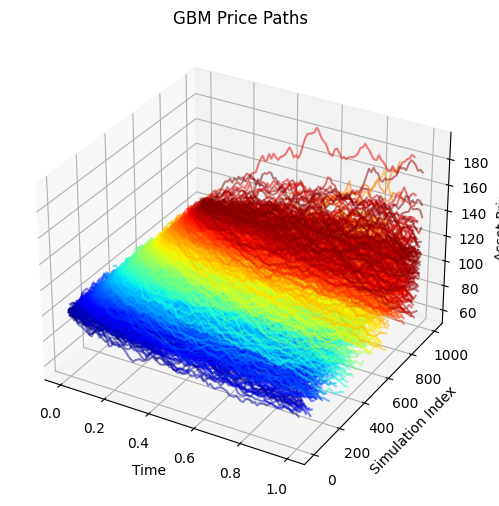

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

class RiskNeutralDiscounting:
    def __init__(self, r):
        self.r = r

    def discount_factor(self, T):
        return np.exp(-self.r * T)

# Initialize GBMModel and RiskNeutralDiscounting
gbm = GBMModel(S0=100, sigma=0.2, r=0.05, T=1)
disc = RiskNeutralDiscounting(r=0.05)

# Generate and plot multiple price paths
n_steps = 100
n_paths = 1000 # Reduced number of paths for better visual effect in 3D plot
price_paths = gbm.generate_price_paths(n_steps, n_paths)

# Create a color map
colors = cm.jet(np.linspace(0, 1, n_paths))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(n_paths):
    xs = np.linspace(0, gbm.T, n_steps)
    ys = [i]*n_steps
    zs = price_paths[:, i]
    ax.plot(xs, ys, zs, color=colors[i], alpha=0.5)

ax.set_title('GBM Price Paths')
ax.set_xlabel('Time')
ax.set_ylabel('Simulation Index')
ax.set_zlabel('Asset Price')
plt.show()


In [ ]:
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors

# Convert matplotlib colormap to Plotly's color scale
jet = cm.get_cmap('jet', 256)
plotly_jet = []

for i in range(jet.N):
    rgb = jet(i)[:3]  # Will return rgba, we remove alpha
    plotly_jet.append(matplotlib.colors.rgb2hex(rgb))

# Convert the price paths to a DataFrame for easier manipulation
price_paths_df = pd.DataFrame(price_paths)

# Create an empty Figure
fig = go.Figure()

# Add a line to the figure for each price path
for i in range(n_paths):
    color = plotly_jet[int((i/n_paths)*255)]  # Scale color selection with simulation index
    fig.add_trace(go.Scatter3d(
        x=np.linspace(0, gbm.T, n_steps),  # Time
        y=[i]*n_steps,  # Simulation index
        z=price_paths_df.iloc[:, i],  # Asset price
        mode='lines',
        line=dict(color=color, width=2),
        showlegend=False,
    ))

# Set the axis labels and figure size
fig.update_layout(scene=dict(
        xaxis_title='Time',
        yaxis_title='Simulation Index',
        zaxis_title='Asset Price'),
    autosize=False,
    width=1200,
    height=800)

# Show the figure
fig.show()


<ipython-input-14-ab6a4f9e32b2>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet', 256)


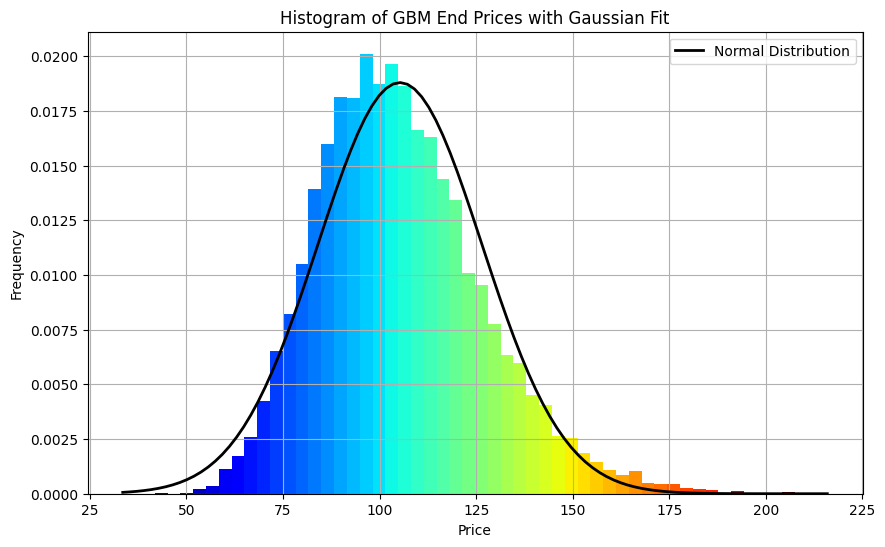

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.stats import norm

# Initialize GBMModel and RiskNeutralDiscounting
gbm = GBMModel(S0=100, sigma=0.2, r=0.05, T=1)
disc = RiskNeutralDiscounting(r=0.05)

# Generate multiple price paths
n_steps = 100
n_paths = 10000
price_paths = gbm.generate_price_paths(n_steps, n_paths)

# Extract the end prices
end_prices = price_paths[-1, :]

# Define the number of bins
n_bins = 50

# Create a color map
colors = cm.jet(np.linspace(0, 1, n_bins))

# Plot the histogram of end prices and get the bin edges
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(end_prices, bins=n_bins, density=True)

# Color each bar of the histogram according to its index
for i in range(len(patches)):
    patches[i].set_facecolor(colors[i])

# Calculate the mean and standard deviation of end prices
mu, std = norm.fit(end_prices)

# Plot the PDF of the Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label="Normal Distribution")

plt.title('Histogram of GBM End Prices with Gaussian Fit')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


European call option price: 10.945773482125755


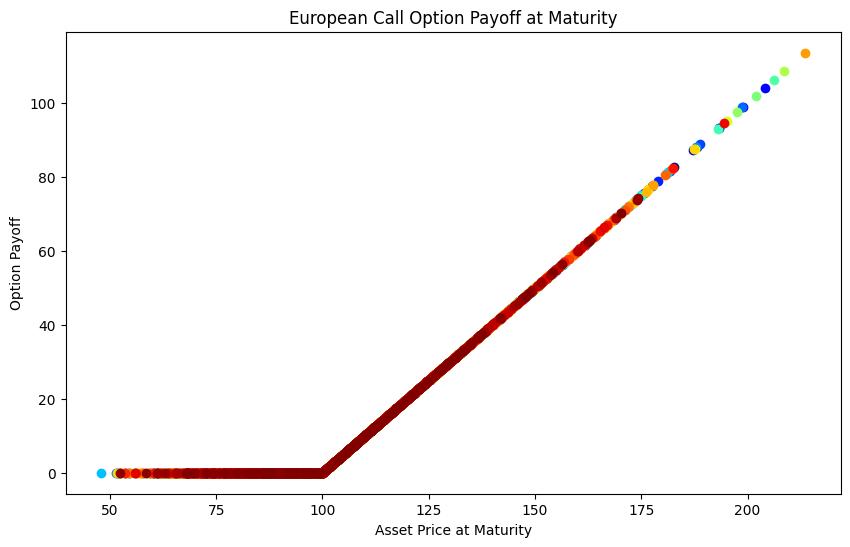

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Initialize a European call option and price it
option = EuropeanOption(GBMModel=gbm, K=100, T=1, option_type='call')
n_simulations = 1000
option_price = option.mc_price(n_simulations, n_steps, disc)
print(f'European call option price: {option_price}')

# Calculate payoffs and average prices for coloring
payoffs = option.payoff(price_paths)
average_prices = price_paths.mean(axis=0)

# Create a color map
colors = cm.jet(np.linspace(0, 1, n_paths))

# Plot option payoff at maturity
plt.figure(figsize=(10, 6))
for i in range(n_paths):
    plt.scatter(price_paths[-1, i], payoffs[i], color=colors[i])
plt.title('European Call Option Payoff at Maturity')
plt.xlabel('Asset Price at Maturity')
plt.ylabel('Option Payoff')
plt.show()


European call option price: 10.818261682798324


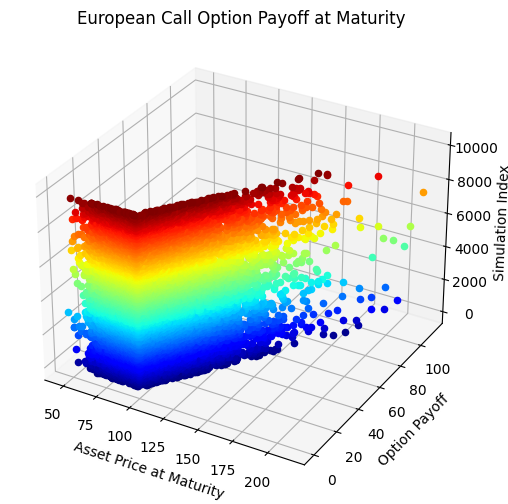

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Initialize a European call option and price it
option = EuropeanOption(GBMModel=gbm, K=100, T=1, option_type='call')
n_simulations = 1000
option_price = option.mc_price(n_simulations, n_steps, disc)
print(f'European call option price: {option_price}')

# Calculate payoffs and average prices for coloring
payoffs = option.payoff(price_paths)
average_prices = price_paths.mean(axis=0)

# Create a color map
colors = cm.jet(np.linspace(0, 1, n_paths))

# Create a new figure and a 3D Axes
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Add data to the 3D scatter plot
for i in range(n_paths):
    ax.scatter(price_paths[-1, i], payoffs[i], i, color=colors[i])

# Set labels and title
ax.set_title('European Call Option Payoff at Maturity')
ax.set_xlabel('Asset Price at Maturity')
ax.set_ylabel('Option Payoff')
ax.set_zlabel('Simulation Index')

plt.show()

European put option price: 5.342324413436473


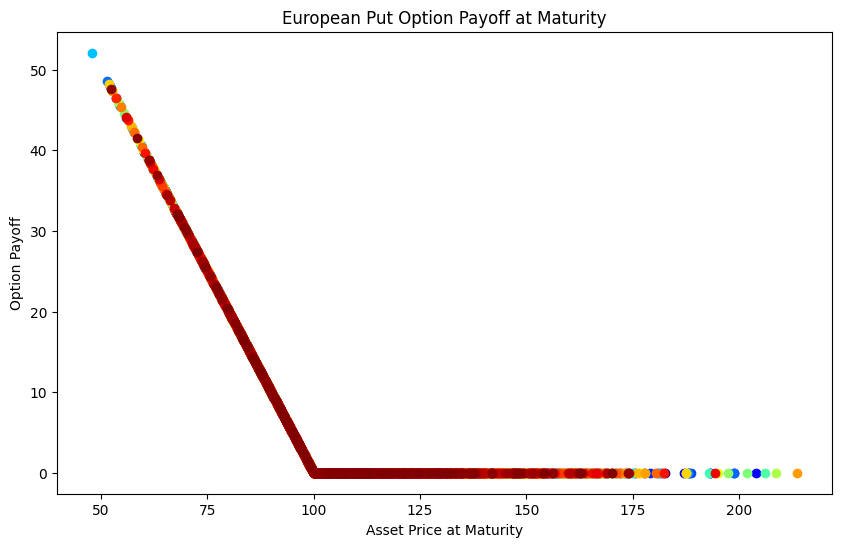

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Initialize a European put option and price it
option = EuropeanOption(GBMModel=gbm, K=100, T=1, option_type='put')
n_simulations = 1000
option_price = option.mc_price(n_simulations, n_steps, disc)
print(f'European put option price: {option_price}')

# Calculate payoffs and average prices for coloring
payoffs = option.payoff(price_paths)
average_prices = price_paths.mean(axis=0)

# Create a color map
colors = cm.jet(np.linspace(0, 1, n_paths))

# Plot option payoff at maturity
plt.figure(figsize=(10, 6))
for i in range(n_paths):
    plt.scatter(price_paths[-1, i], payoffs[i], color=colors[i])
plt.title('European Put Option Payoff at Maturity')
plt.xlabel('Asset Price at Maturity')
plt.ylabel('Option Payoff')
plt.show()


European put option price: 5.533077205508913


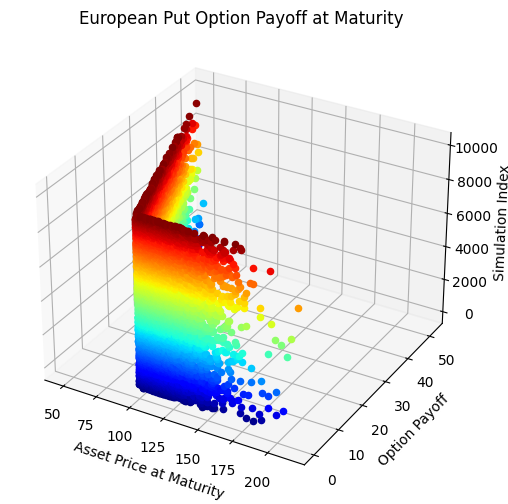

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Initialize a European put option and price it
option = EuropeanOption(GBMModel=gbm, K=100, T=1, option_type='put')
n_simulations = 1000
option_price = option.mc_price(n_simulations, n_steps, disc)
print(f'European put option price: {option_price}')

# Calculate payoffs and average prices for coloring
payoffs = option.payoff(price_paths)
average_prices = price_paths.mean(axis=0)

# Create a color map
colors = cm.jet(np.linspace(0, 1, n_paths))

# Create a new figure and a 3D Axes
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Add data to the 3D scatter plot
for i in range(n_paths):
    ax.scatter(price_paths[-1, i], payoffs[i], i, color=colors[i])

# Set labels and title
ax.set_title('European Put Option Payoff at Maturity')
ax.set_xlabel('Asset Price at Maturity')
ax.set_ylabel('Option Payoff')
ax.set_zlabel('Simulation Index')

plt.show()

European Lookback Call Option (Fixed Strike) Price: 17.474034561682103


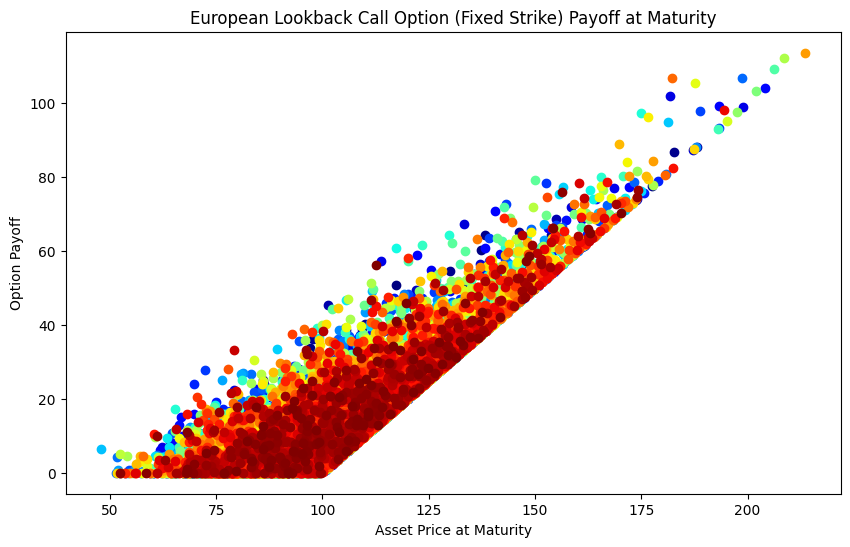

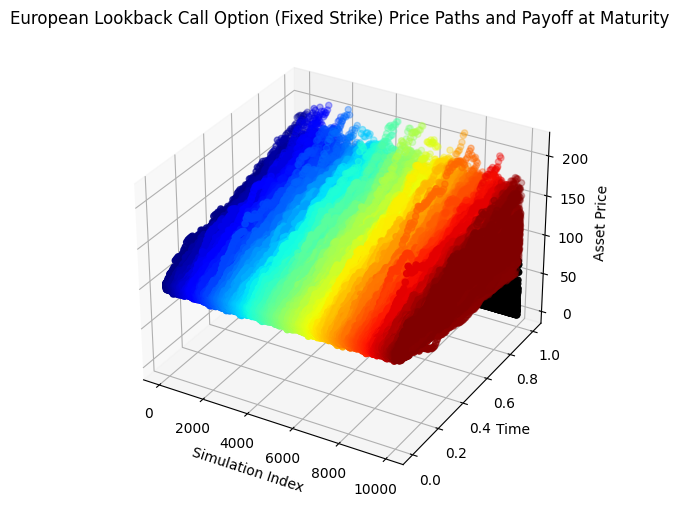

In [ ]:
# 2D Scatter plot with color mapping
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Initialize a European lookback call option with a fixed strike and price it
option = LookbackOption(GBMModel=gbm, K=100, T=1, option_type='call', fixed_strike=True)
option_price = option.mc_price(n_simulations, n_steps, disc)
print(f'European Lookback Call Option (Fixed Strike) Price: {option_price}')

# Calculate payoffs and average prices for coloring
payoffs = option.payoff(price_paths)
average_prices = price_paths.mean(axis=0)

# Create a color map
colors = cm.jet(np.linspace(0, 1, n_paths))

# Plot option payoff at maturity
plt.figure(figsize=(10, 6))
for i in range(n_paths):
    plt.scatter(price_paths[-1, i], payoffs[i], color=colors[i])
plt.title('European Lookback Call Option (Fixed Strike) Payoff at Maturity')
plt.xlabel('Asset Price at Maturity')
plt.ylabel('Option Payoff')
plt.show()

# 3D Scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(n_paths):
    ax.scatter(np.ones(n_steps) * i, np.linspace(0, gbm.T, n_steps), price_paths[:, i], color=colors[i])
ax.scatter(np.linspace(0, n_paths, n_paths), np.ones(n_paths) * gbm.T, payoffs, c='black', marker='o')
plt.title('European Lookback Call Option (Fixed Strike) Price Paths and Payoff at Maturity')
ax.set_xlabel('Simulation Index')
ax.set_ylabel('Time')
ax.set_zlabel('Asset Price')
plt.show()


European Lookback Call Option (Floating Strike) Price: 16.31399103775241


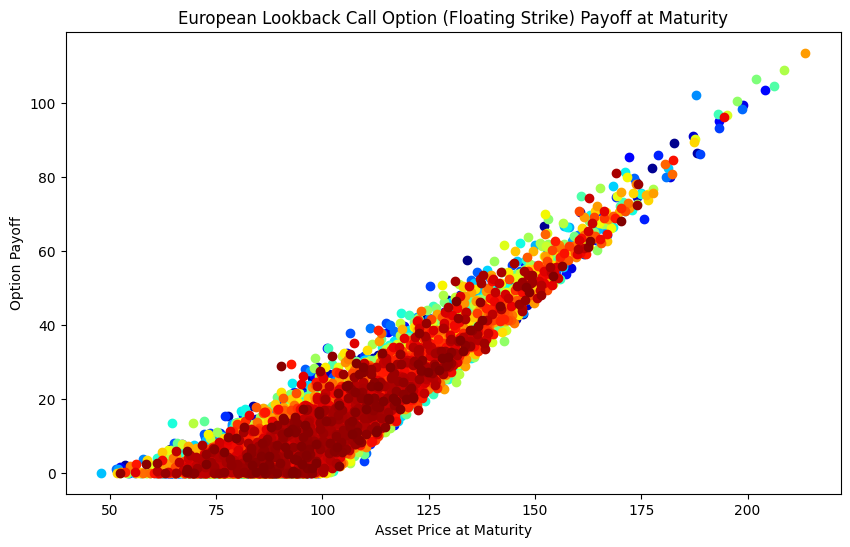

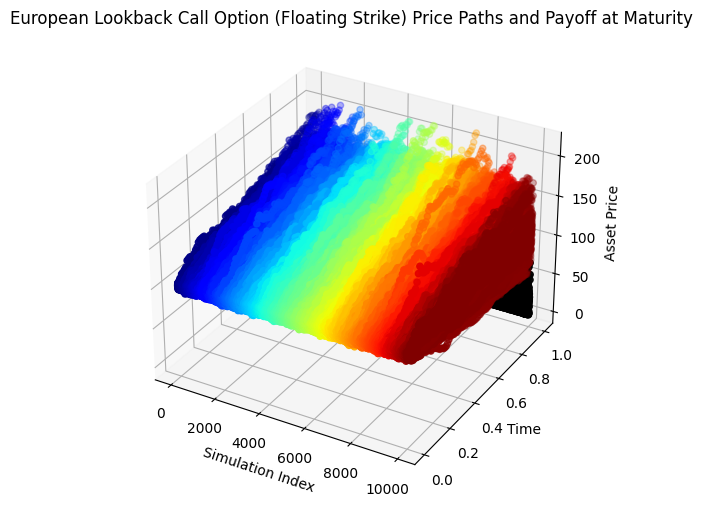

In [ ]:
# 2D Scatter plot with color mapping
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Initialize a European lookback call option with a floating strike and price it
option = LookbackOption(GBMModel=gbm, K=100, T=1, option_type='call', fixed_strike=False)
option_price = option.mc_price(n_simulations, n_steps, disc)
print(f'European Lookback Call Option (Floating Strike) Price: {option_price}')

# Calculate payoffs and average prices for coloring
payoffs = option.payoff(price_paths)
average_prices = price_paths.mean(axis=0)

# Create a color map
colors = cm.jet(np.linspace(0, 1, n_paths))

# Plot option payoff at maturity
plt.figure(figsize=(10, 6))
for i in range(n_paths):
    plt.scatter(price_paths[-1, i], payoffs[i], color=colors[i])
plt.title('European Lookback Call Option (Floating Strike) Payoff at Maturity')
plt.xlabel('Asset Price at Maturity')
plt.ylabel('Option Payoff')
plt.show()

# 3D Scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(n_paths):
    ax.scatter(np.ones(n_steps) * i, np.linspace(0, gbm.T, n_steps), price_paths[:, i], color=colors[i])
ax.scatter(np.linspace(0, n_paths, n_paths), np.ones(n_paths) * gbm.T, payoffs, c='black', marker='o')
plt.title('European Lookback Call Option (Floating Strike) Price Paths and Payoff at Maturity')
ax.set_xlabel('Simulation Index')
ax.set_ylabel('Time')
ax.set_zlabel('Asset Price')
plt.show()


European Lookback Put Option (Fixed Strike) Price: 11.857764772163563


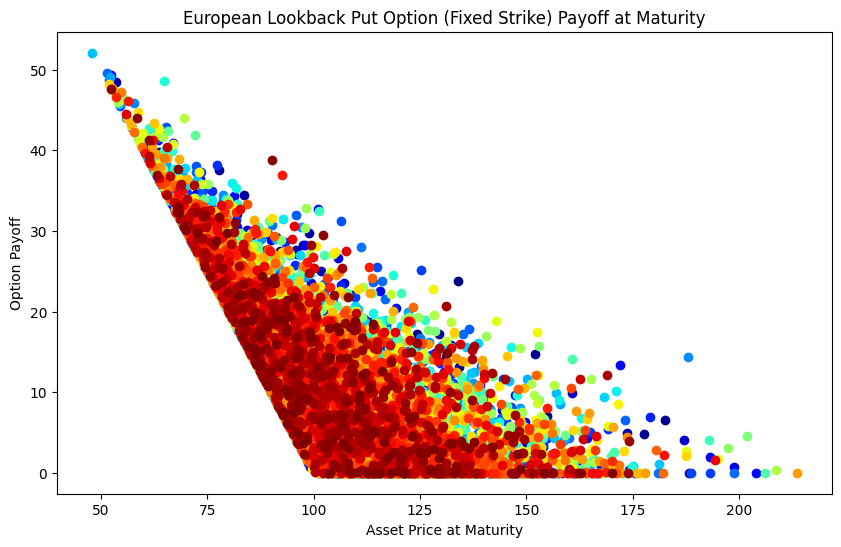

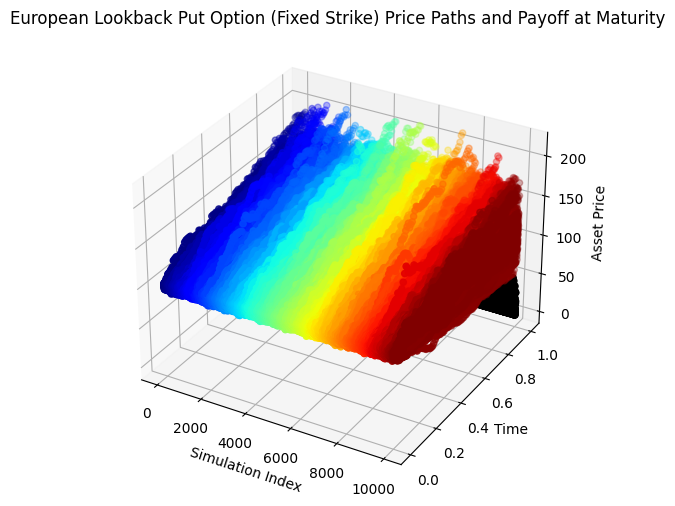

In [ ]:
# 2D Scatter plot with color mapping
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Initialize a European lookback put option with a fixed strike and price it
option = LookbackOption(GBMModel=gbm, K=100, T=1, option_type='put', fixed_strike=True)
option_price = option.mc_price(n_simulations, n_steps, disc)
print(f'European Lookback Put Option (Fixed Strike) Price: {option_price}')

# Calculate payoffs and average prices for coloring
payoffs = option.payoff(price_paths)
average_prices = price_paths.mean(axis=0)

# Create a color map
colors = cm.jet(np.linspace(0, 1, n_paths))

# Plot option payoff at maturity
plt.figure(figsize=(10, 6))
for i in range(n_paths):
    plt.scatter(price_paths[-1, i], payoffs[i], color=colors[i])
plt.title('European Lookback Put Option (Fixed Strike) Payoff at Maturity')
plt.xlabel('Asset Price at Maturity')
plt.ylabel('Option Payoff')
plt.show()

# 3D Scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(n_paths):
    ax.scatter(np.ones(n_steps) * i, np.linspace(0, gbm.T, n_steps), price_paths[:, i], color=colors[i])
ax.scatter(np.linspace(0, n_paths, n_paths), np.ones(n_paths) * gbm.T, payoffs, c='black', marker='o')
plt.title('European Lookback Put Option (Fixed Strike) Price Paths and Payoff at Maturity')
ax.set_xlabel('Simulation Index')
ax.set_ylabel('Time')
ax.set_zlabel('Asset Price')
plt.show()


European Lookback Put Option (Floating Strike) Price: 12.942357228673167


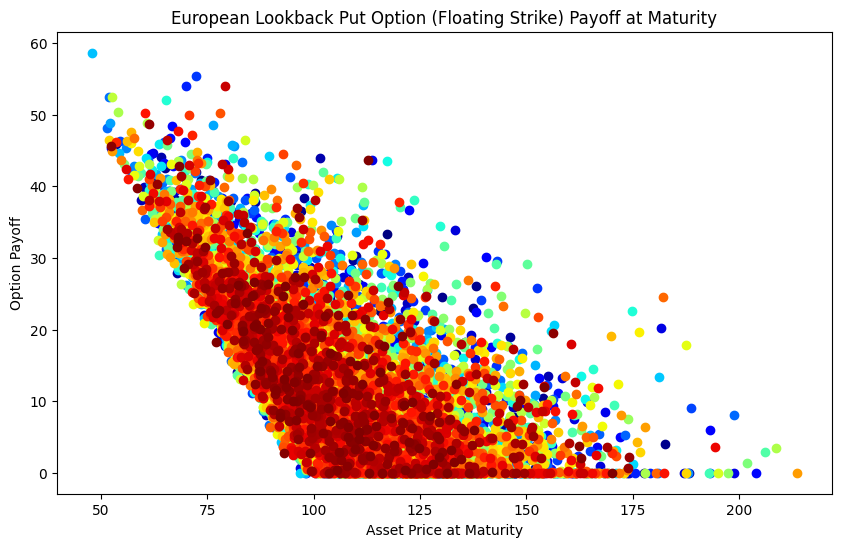

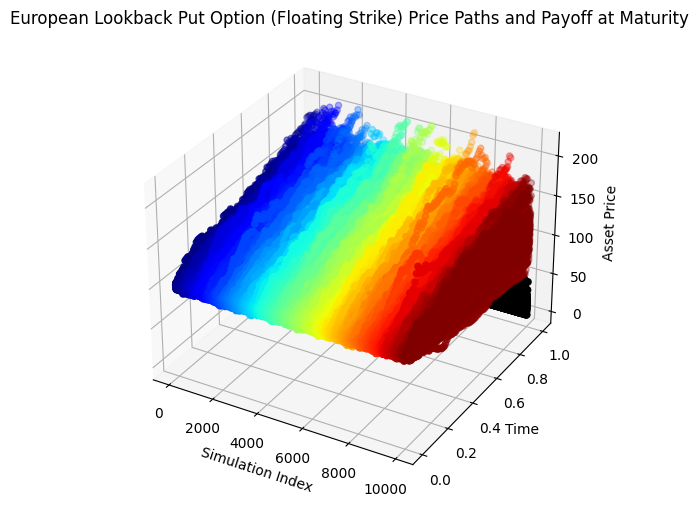

In [ ]:
# 2D Scatter plot with color mapping
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Initialize a European lookback put option with a floating strike and price it
option = LookbackOption(GBMModel=gbm, K=100, T=1, option_type='put', fixed_strike=False)
option_price = option.mc_price(n_simulations, n_steps, disc)
print(f'European Lookback Put Option (Floating Strike) Price: {option_price}')

# Calculate payoffs and average prices for coloring
payoffs = option.payoff(price_paths)
average_prices = price_paths.mean(axis=0)

# Create a color map
colors = cm.jet(np.linspace(0, 1, n_paths))

# Plot option payoff at maturity
plt.figure(figsize=(10, 6))
for i in range(n_paths):
    plt.scatter(price_paths[-1, i], payoffs[i], color=colors[i])
plt.title('European Lookback Put Option (Floating Strike) Payoff at Maturity')
plt.xlabel('Asset Price at Maturity')
plt.ylabel('Option Payoff')
plt.show()

# 3D Scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(n_paths):
    ax.scatter(np.ones(n_steps) * i, np.linspace(0, gbm.T, n_steps), price_paths[:, i], color=colors[i])
ax.scatter(np.linspace(0, n_paths, n_paths), np.ones(n_paths) * gbm.T, payoffs, c='black', marker='o')
plt.title('European Lookback Put Option (Floating Strike) Price Paths and Payoff at Maturity')
ax.set_xlabel('Simulation Index')
ax.set_ylabel('Time')
ax.set_zlabel('Asset Price')
plt.show()


European Asian Call Option (Fixed Price) Price: 5.636472657414915


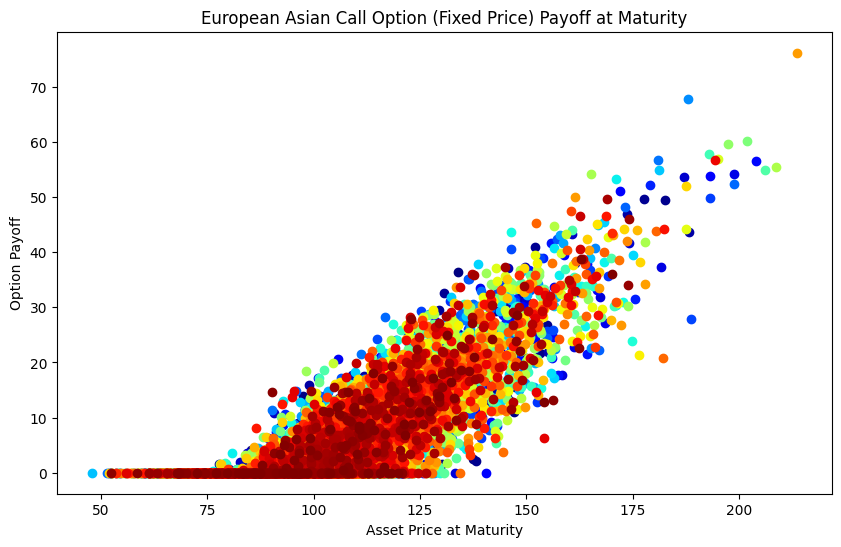

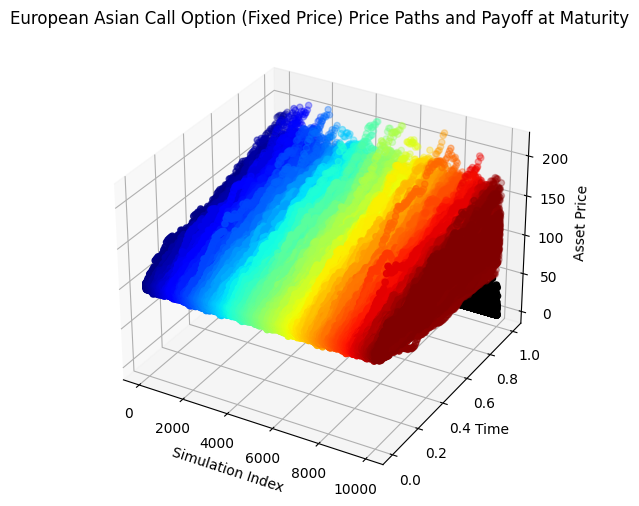

In [ ]:
# 2D Scatter plot with color mapping
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Initialize a European Asian call option with a fixed price and price it
option = AsianOption(GBMModel=gbm, K=100, T=1, option_type='call', fixed_strike=False)
option_price = option.mc_price(n_simulations, n_steps, disc)
print(f'European Asian Call Option (Fixed Price) Price: {option_price}')

# Calculate payoffs and average prices for coloring
payoffs = option.payoff(price_paths)
average_prices = price_paths.mean(axis=0)

# Create a color map
colors = cm.jet(np.linspace(0, 1, n_paths))

# Plot option payoff at maturity
plt.figure(figsize=(10, 6))
for i in range(n_paths):
    plt.scatter(price_paths[-1, i], payoffs[i], color=colors[i])
plt.title('European Asian Call Option (Fixed Price) Payoff at Maturity')
plt.xlabel('Asset Price at Maturity')
plt.ylabel('Option Payoff')
plt.show()

# 3D Scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(n_paths):
    ax.scatter(np.ones(n_steps) * i, np.linspace(0, gbm.T, n_steps), price_paths[:, i], color=colors[i])
ax.scatter(np.linspace(0, n_paths, n_paths), np.ones(n_paths) * gbm.T, payoffs, c='black', marker='o')
plt.title('European Asian Call Option (Fixed Price) Price Paths and Payoff at Maturity')
ax.set_xlabel('Simulation Index')
ax.set_ylabel('Time')
ax.set_zlabel('Asset Price')
plt.show()


European Asian Put Option (Fixed Price) Price: 3.238428969840497


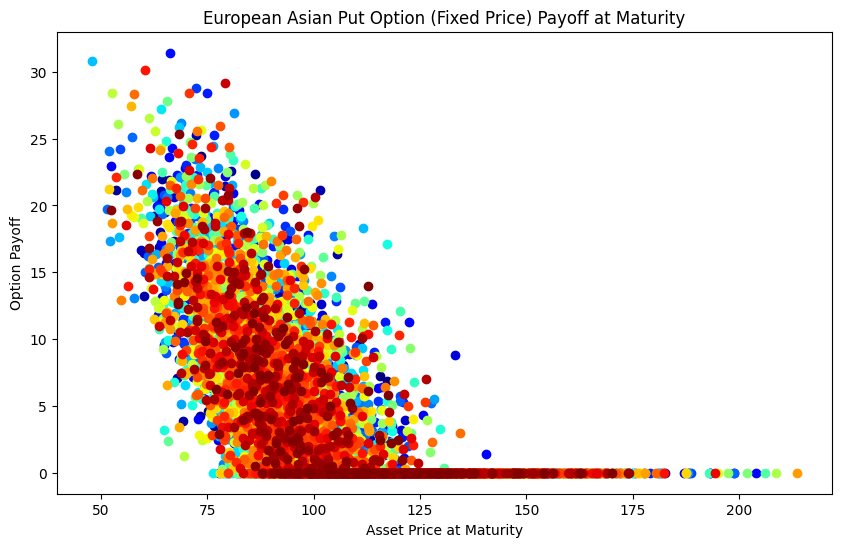

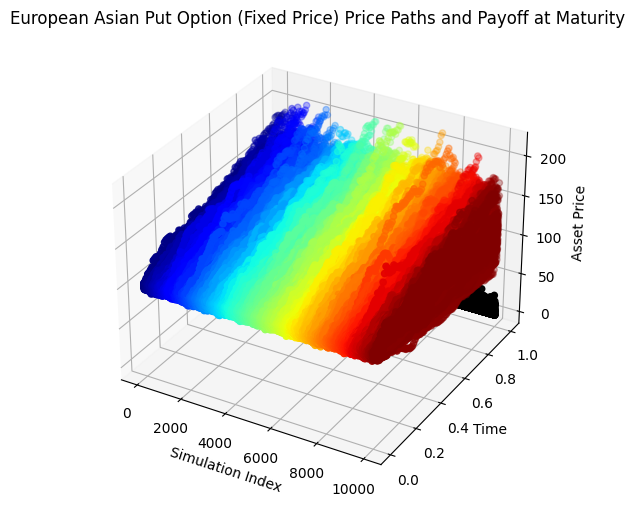

In [ ]:
# 2D Scatter plot with color mapping
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Initialize a European Asian put option with a fixed price and price it
option = AsianOption(GBMModel=gbm, K=100, T=1, option_type='put', fixed_strike=False) # Assuming 'fixed price' is the same as 'floating strike'
option_price = option.mc_price(n_simulations, n_steps, disc)
print(f'European Asian Put Option (Fixed Price) Price: {option_price}')

# Calculate payoffs and average prices for coloring
payoffs = option.payoff(price_paths)
average_prices = price_paths.mean(axis=0)

# Create a color map
colors = cm.jet(np.linspace(0, 1, n_paths))

# Plot option payoff at maturity
plt.figure(figsize=(10, 6))
for i in range(n_paths):
    plt.scatter(price_paths[-1, i], payoffs[i], color=colors[i])
plt.title('European Asian Put Option (Fixed Price) Payoff at Maturity')
plt.xlabel('Asset Price at Maturity')
plt.ylabel('Option Payoff')
plt.show()

# 3D Scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(n_paths):
    ax.scatter(np.ones(n_steps) * i, np.linspace(0, gbm.T, n_steps), price_paths[:, i], color=colors[i])
ax.scatter(np.linspace(0, n_paths, n_paths), np.ones(n_paths) * gbm.T, payoffs, c='black', marker='o')
plt.title('European Asian Put Option (Fixed Price) Price Paths and Payoff at Maturity')
ax.set_xlabel('Simulation Index')
ax.set_ylabel('Time')
ax.set_zlabel('Asset Price')
plt.show()


European Asian Put Option (Fixed Strike) Price: 3.470203380858222


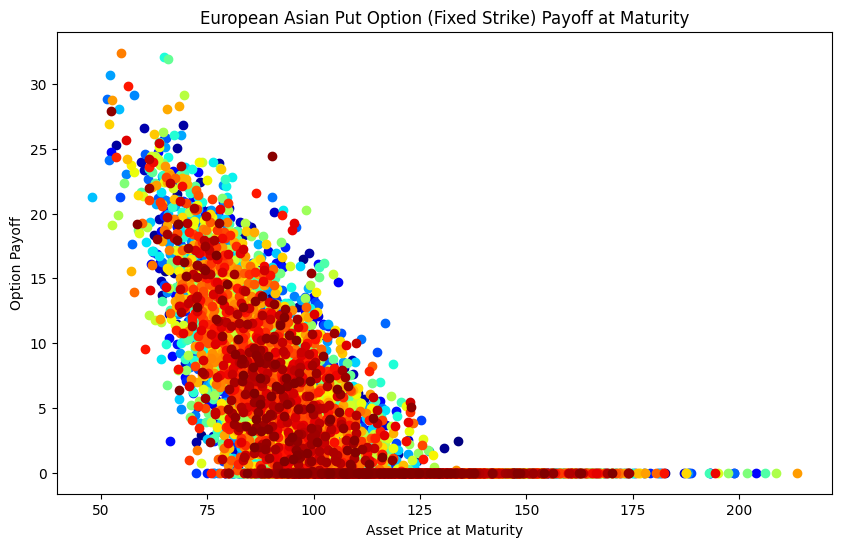

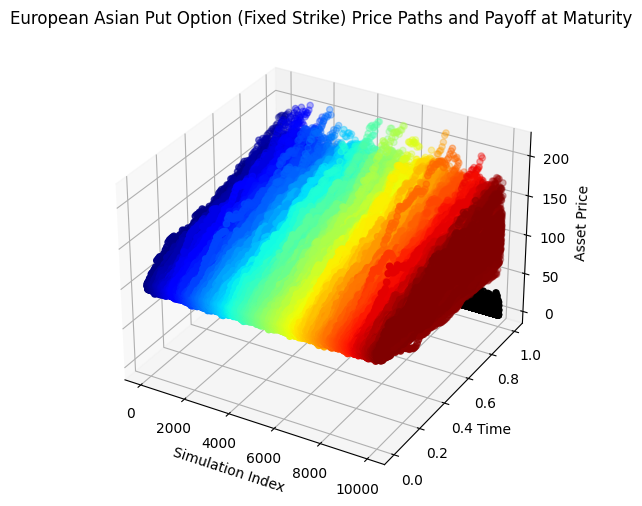

In [ ]:
# 2D Scatter plot with color mapping
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Initialize a European Asian put option with a fixed strike and price it
option = AsianOption(GBMModel=gbm, K=100, T=1, option_type='put', fixed_strike=True)
option_price = option.mc_price(n_simulations, n_steps, disc)
print(f'European Asian Put Option (Fixed Strike) Price: {option_price}')

# Calculate payoffs and average prices for coloring
payoffs = option.payoff(price_paths)
average_prices = price_paths.mean(axis=0)

# Create a color map
colors = cm.jet(np.linspace(0, 1, n_paths))

# Plot option payoff at maturity
plt.figure(figsize=(10, 6))
for i in range(n_paths):
    plt.scatter(price_paths[-1, i], payoffs[i], color=colors[i])
plt.title('European Asian Put Option (Fixed Strike) Payoff at Maturity')
plt.xlabel('Asset Price at Maturity')
plt.ylabel('Option Payoff')
plt.show()

# 3D Scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(n_paths):
    ax.scatter(np.ones(n_steps) * i, np.linspace(0, gbm.T, n_steps), price_paths[:, i], color=colors[i])
ax.scatter(np.linspace(0, n_paths, n_paths), np.ones(n_paths) * gbm.T, payoffs, c='black', marker='o')
plt.title('European Asian Put Option (Fixed Strike) Price Paths and Payoff at Maturity')
ax.set_xlabel('Simulation Index')
ax.set_ylabel('Time')
ax.set_zlabel('Asset Price')
plt.show()


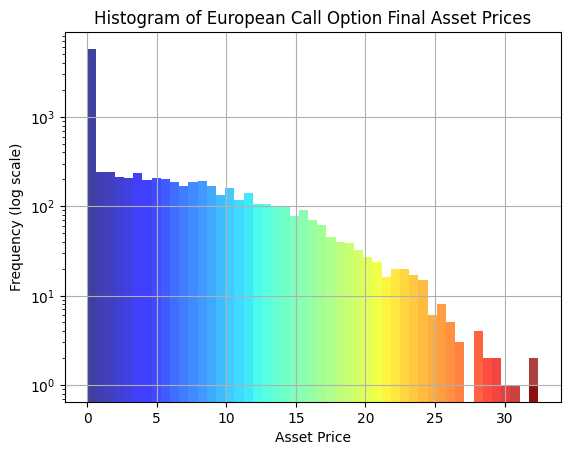

In [ ]:
import matplotlib.colors as mcolors
import numpy as np

# Normalize payoffs to [0, 1]
norm = plt.Normalize(payoffs.min(), payoffs.max())
colors = plt.cm.jet(norm(payoffs))

# Sort payoffs and colors by payoff
sort_idx = np.argsort(payoffs)
payoffs, colors = payoffs[sort_idx], colors[sort_idx]

# Calculate bin edges
bins = np.linspace(payoffs.min(), payoffs.max(), 50)

# Calculate bin indices for each payoff
bin_idx = np.digitize(payoffs, bins)

# Plot histogram with colors
for b in np.unique(bin_idx):
    plt.hist(payoffs[bin_idx == b], bins=bins, alpha=0.75, color=colors[bin_idx == b][0])

plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Histogram of European Call Option Final Asset Prices')
plt.xlabel('Asset Price')
plt.ylabel('Frequency (log scale)')
plt.grid(True)
plt.show()


In [ ]:
S0 = 100.0  # Initial asset price
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
T = 1.0  # Time to maturity
K = 100  # Strike price
n_simulations = 1000  # Number of price paths
n_steps = 200  # Number of steps

In [ ]:
gbm = GBMModel(S0, sigma, r, T)

euro_put = EuropeanOption(gbm, K, T, 'put')
lookback_call_fixed = LookbackOption(gbm, K, T, 'call', True)
lookback_call_float = LookbackOption(gbm, K, T, 'call', False)
lookback_put_fixed = LookbackOption(gbm, K, T, 'put', True)
lookback_put_float = LookbackOption(gbm, K, T, 'put', False)
asian_call_fixed = AsianOption(gbm, K, T, 'call', True)
asian_call_float = AsianOption(gbm, K, T, 'call', False)
asian_put_fixed = AsianOption(gbm, K, T, 'put', True)
asian_put_float = AsianOption(gbm, K, T, 'put', False)

In [ ]:
options = {
    'European Put Option': euro_put,
    'Lookback Call Option (Fixed Strike)': lookback_call_fixed,
    'Lookback Call Option (Floating Strike)': lookback_call_float,
    'Lookback Put Option (Fixed Strike)': lookback_put_fixed,
    'Lookback Put Option (Floating Strike)': lookback_put_float,
    'Asian Call Option (Fixed Strike)': asian_call_fixed,
    'Asian Call Option (Floating Strike)': asian_call_float,
    'Asian Put Option (Fixed Strike)': asian_put_fixed,
    'Asian Put Option (Floating Strike)': asian_put_float,
}


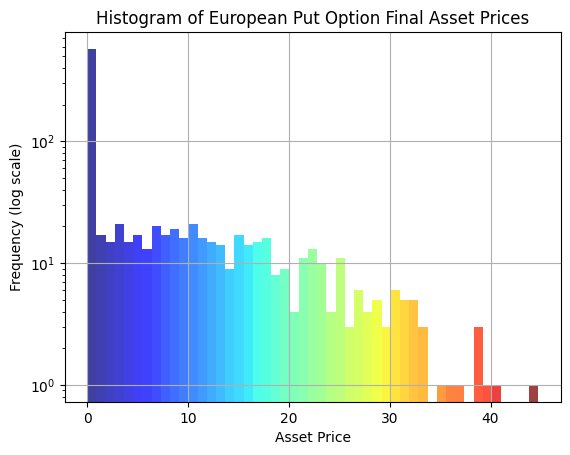

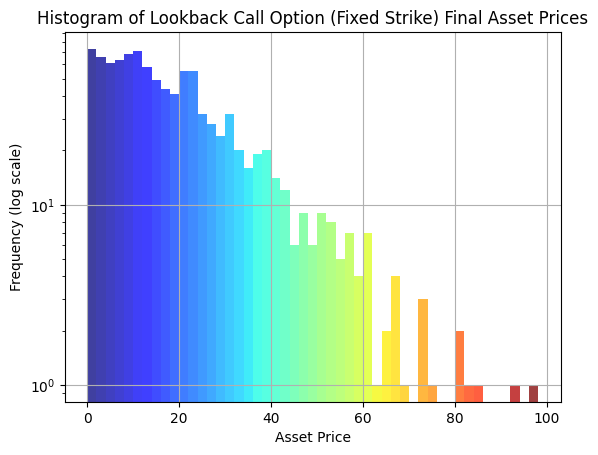

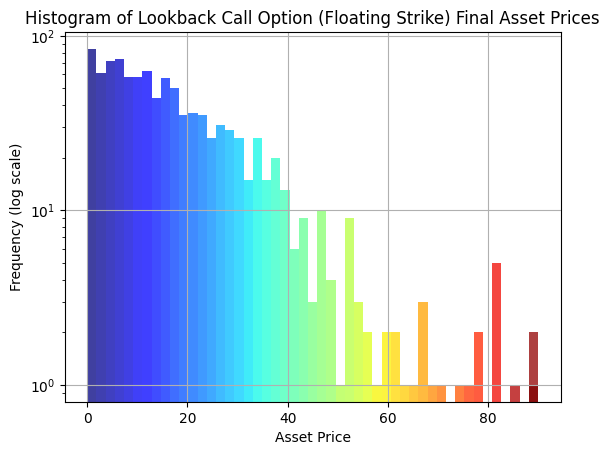

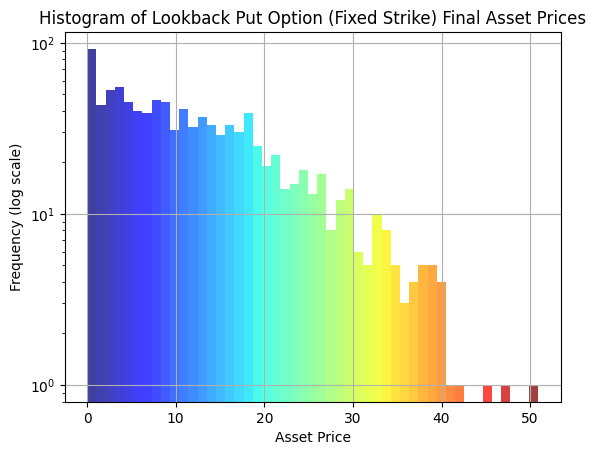

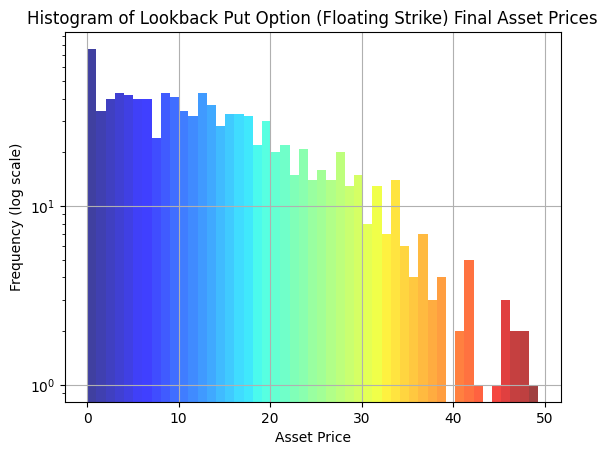

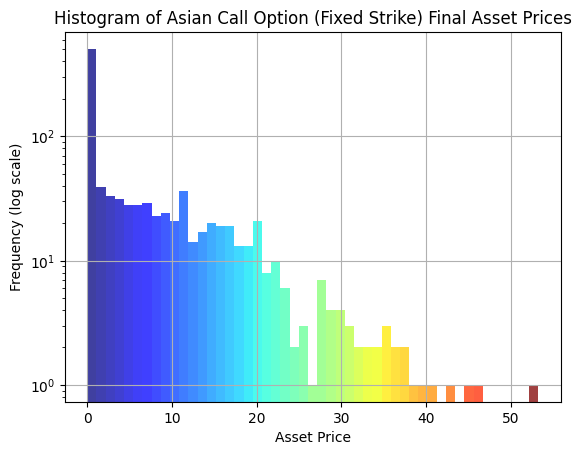

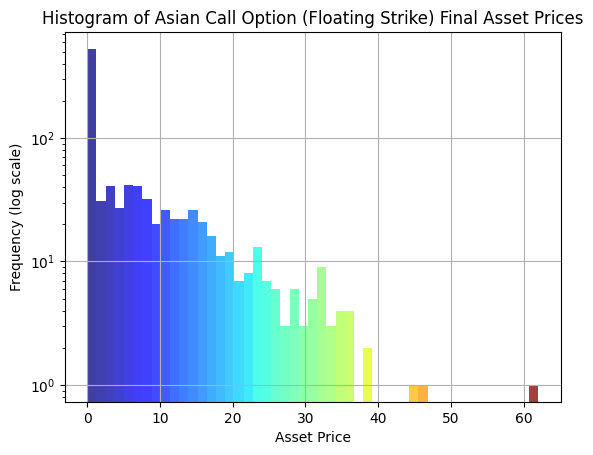

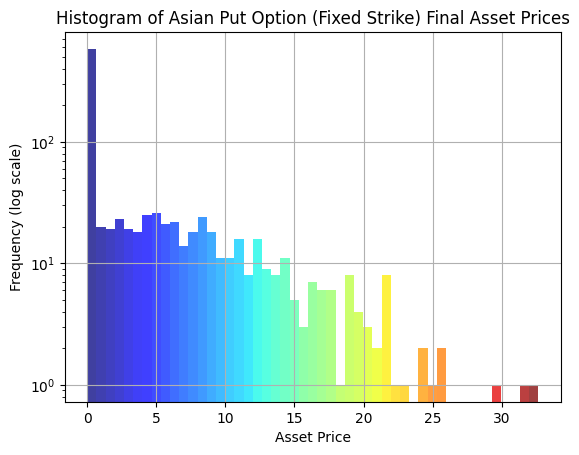

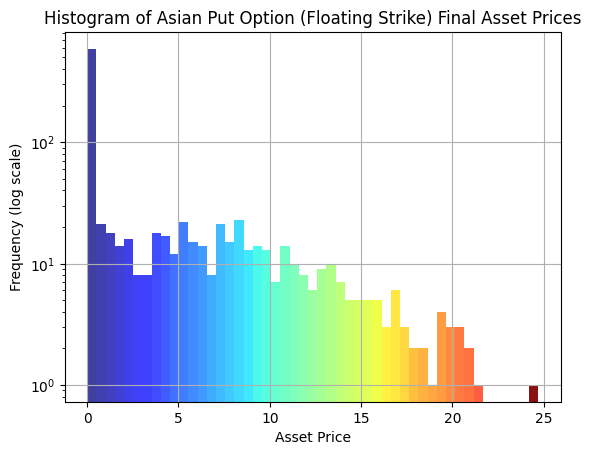

In [ ]:
for name, option in options.items():
    price_paths = gbm.generate_price_paths(n_steps, n_simulations)
    payoffs = option.payoff(price_paths)

    # Normalize payoffs to [0, 1]
    norm = plt.Normalize(payoffs.min(), payoffs.max())
    colors = plt.cm.jet(norm(payoffs))

    # Sort payoffs and colors by payoff
    sort_idx = np.argsort(payoffs)
    payoffs, colors = payoffs[sort_idx], colors[sort_idx]

    # Calculate bin edges
    bins = np.linspace(payoffs.min(), payoffs.max(), 50)

    # Calculate bin indices for each payoff
    bin_idx = np.digitize(payoffs, bins)

    # Plot histogram with colors
    plt.figure()
    for b in np.unique(bin_idx):
        plt.hist(payoffs[bin_idx == b], bins=bins, alpha=0.75, color=colors[bin_idx == b][0])

    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.title(f'Histogram of {name} Final Asset Prices')
    plt.xlabel('Asset Price')
    plt.ylabel('Frequency (log scale)')
    plt.grid(True)
    plt.show()


<ipython-input-34-409c8ead3845>:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



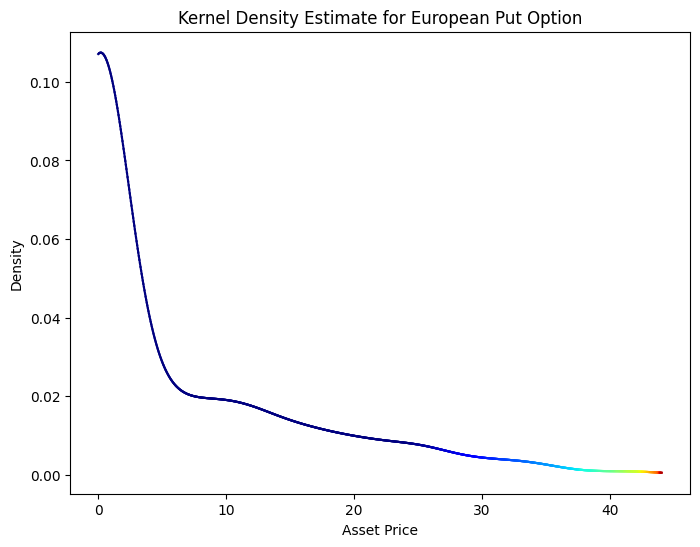

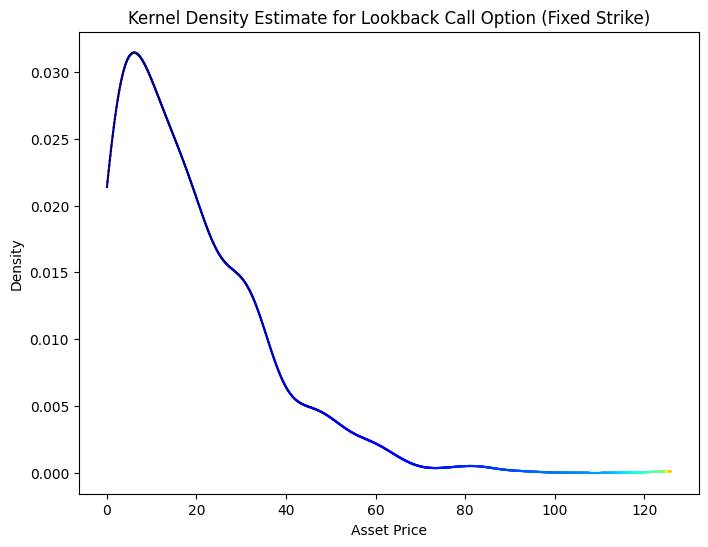

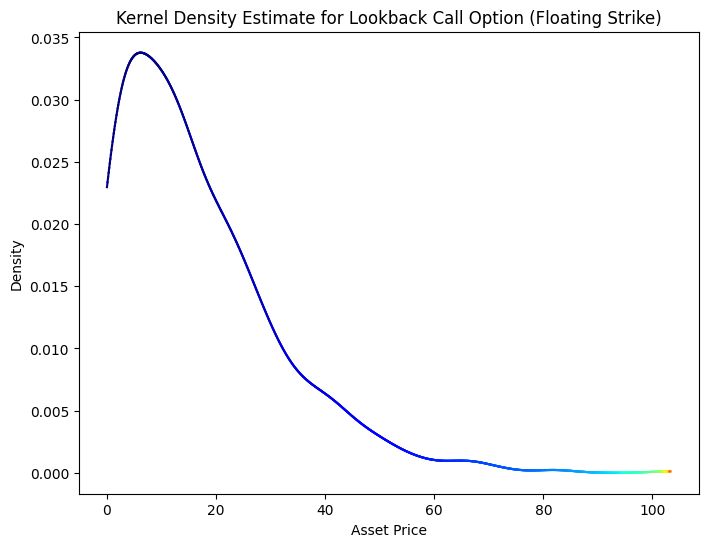

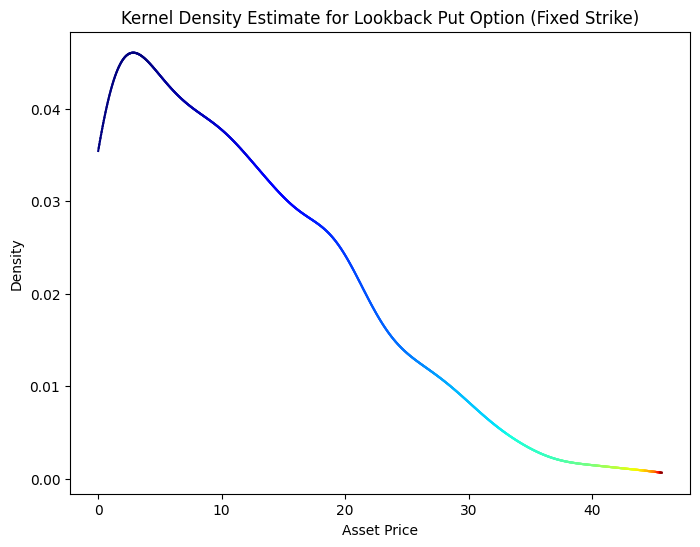

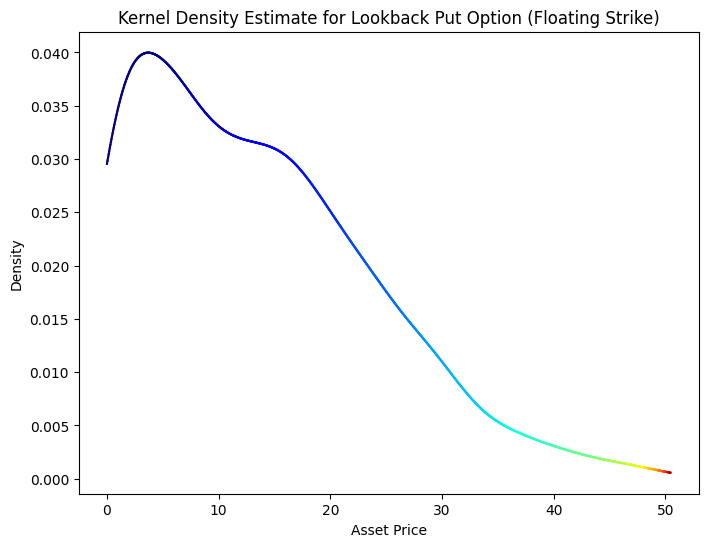

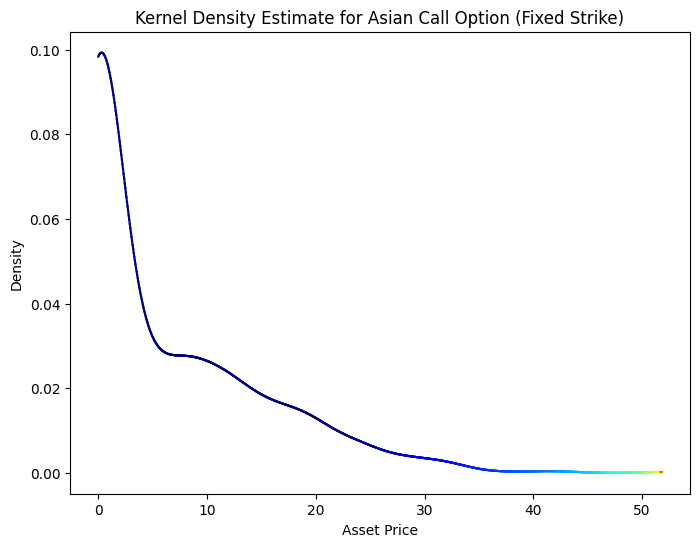

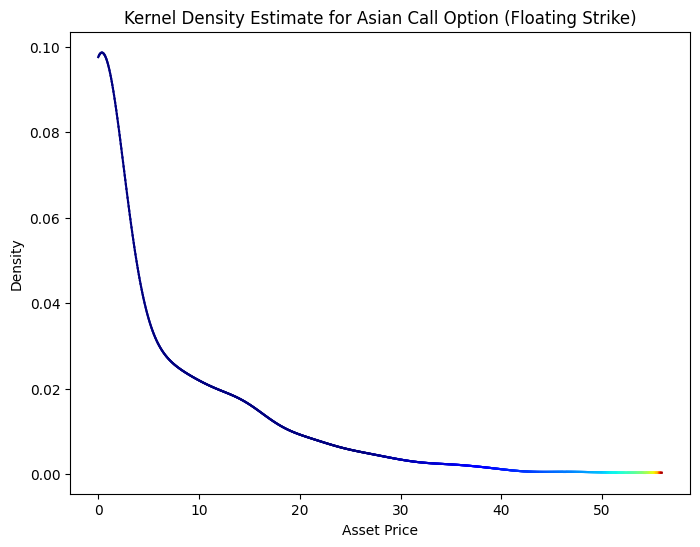

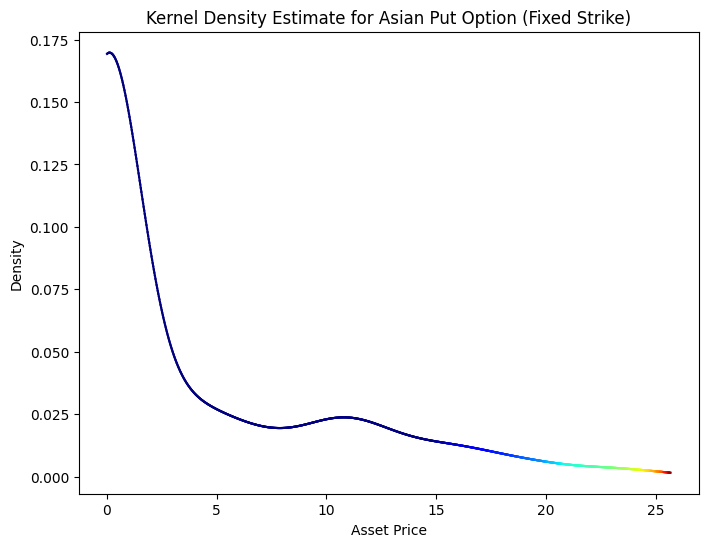

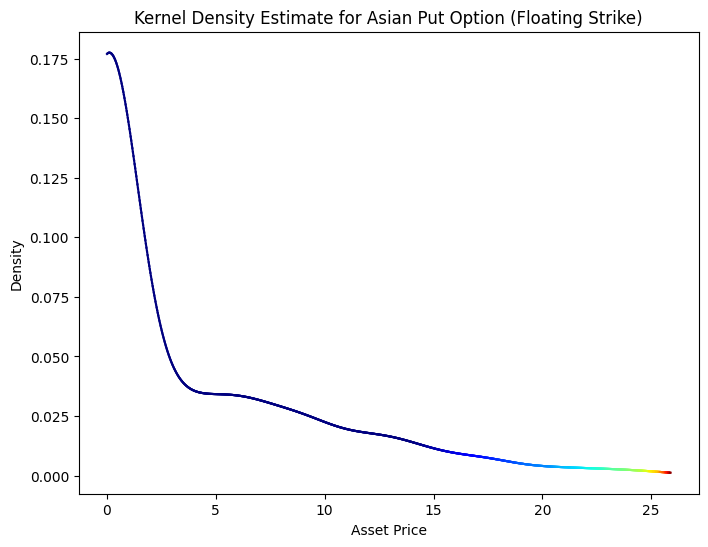

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import gaussian_kde

# Define a colormap
cmap = cm.get_cmap('jet')

# Common parameters
S0 = 100.0  # Initial asset price
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
T = 1.0  # Time to maturity
K = 100  # Strike price
n_simulations = 1000  # Number of price paths
n_steps = 100  # Number of steps

# Instantiate GBM model
gbm = GBMModel(S0, sigma, r, T)

# Instantiate each option
options = {
    'European Put Option': EuropeanOption(gbm, K, T, 'put'),
    'Lookback Call Option (Fixed Strike)': LookbackOption(gbm, K, T, 'call', True),
    'Lookback Call Option (Floating Strike)': LookbackOption(gbm, K, T, 'call', False),
    'Lookback Put Option (Fixed Strike)': LookbackOption(gbm, K, T, 'put', True),
    'Lookback Put Option (Floating Strike)': LookbackOption(gbm, K, T, 'put', False),
    'Asian Call Option (Fixed Strike)': AsianOption(gbm, K, T, 'call', True),
    'Asian Call Option (Floating Strike)': AsianOption(gbm, K, T, 'call', False),
    'Asian Put Option (Fixed Strike)': AsianOption(gbm, K, T, 'put', True),
    'Asian Put Option (Floating Strike)': AsianOption(gbm, K, T, 'put', False),
}

# Iterate over options
for option_name, option in options.items():
    # Generate price paths
    price_paths = gbm.generate_price_paths(n_steps, n_simulations)

    # Calculate payoff
    payoffs = option.payoff(price_paths)

    # Estimate KDE
    kde = gaussian_kde(payoffs)

    # Normalize to [0,1]
    norm = plt.Normalize(payoffs.min(), payoffs.max())
    colors = cmap(norm(payoffs))

    # Sort colors by payoff
    sort_idx = np.argsort(payoffs)
    colors = colors[sort_idx]

    # Plot KDE
    plt.figure(figsize=(8, 6))
    x_vals = np.linspace(payoffs.min(), payoffs.max(), 1000)
    y_vals = kde(x_vals)

    for i in range(len(x_vals) - 1):
        plt.plot(x_vals[i:i+2], y_vals[i:i+2], color=colors[i])

    plt.title(f'Kernel Density Estimate for {option_name}')
    plt.xlabel('Asset Price')
    plt.ylabel('Density')
    plt.show()


<ipython-input-35-0b8569c8e3d7>:46: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



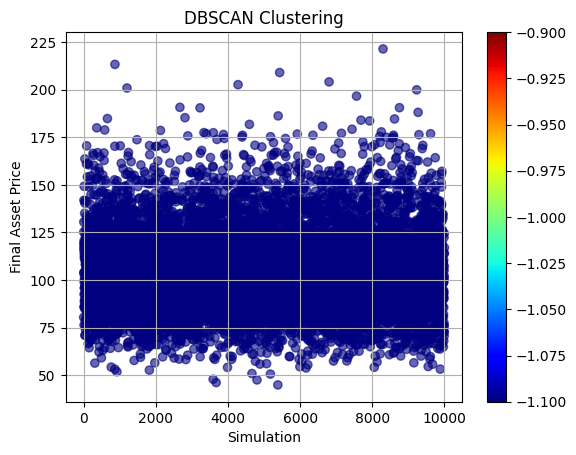

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np

# Initialize GBM parameters
S0 = 100
sigma = 0.2
r = 0.05
T = 1

# Initialize GBM model
gbm_model = GBMModel(S0, sigma, r, T)

# Generate price paths
n_steps = 100
n_paths = 10000
price_paths = gbm_model.generate_price_paths(n_steps, n_paths)

# We'll be clustering on the final asset prices
final_prices = price_paths[-1, :].reshape(-1, 1)

# Scale the data
scaler = StandardScaler()
scaled_prices = scaler.fit_transform(final_prices)

# Apply DBSCAN clustering
# The parameters eps and min_samples need to be adjusted according to your data
db = DBSCAN(eps=0.003, min_samples=1000)
db.fit(scaled_prices)

labels = db.labels_

# Generate colormap
cmap = plt.cm.jet
norm = plt.Normalize(vmin=labels.min(), vmax=labels.max())
colors = cmap(norm(labels))

# Visualize the clusters
plt.figure()
plt.scatter(range(len(final_prices)), final_prices, c=colors, alpha=0.6)
plt.xlabel('Simulation')
plt.ylabel('Final Asset Price')
plt.title('DBSCAN Clustering')
plt.grid(True)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
plt.show()


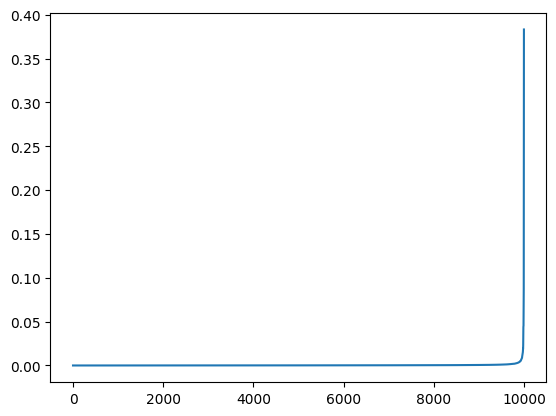

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Fit the nearest neighbors estimator to the data
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(scaled_prices)
distances, indices = nbrs.kneighbors(scaled_prices)

# Sort and plot the distances
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)


In [ ]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors
import numpy as np

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(scaled_prices)
distances, indices = nbrs.kneighbors(scaled_prices)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

knee_locator = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')

print("Estimated optimal eps:", knee_locator.knee_y)


Estimated optimal eps: 0.20173790917289125


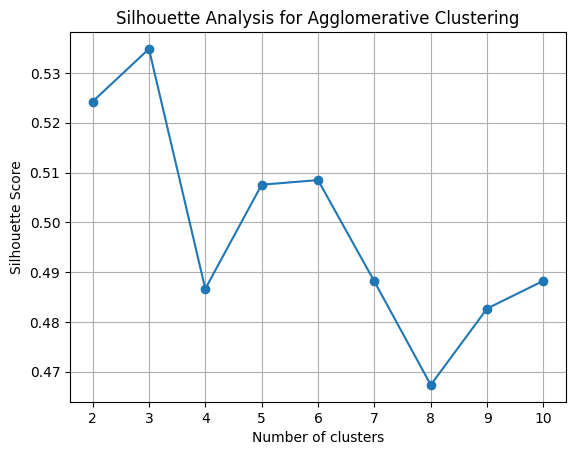

<ipython-input-40-48275eb47170>:37: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



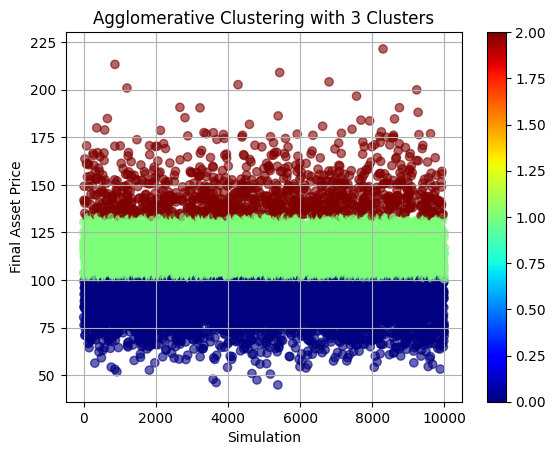

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Determine optimal number of clusters using silhouette analysis
silhouette_scores = []  # list to hold silhouette score for each number of clusters
for n_clusters in range(2, 11):
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agglomerative.fit_predict(scaled_prices)
    silhouette_scores.append(silhouette_score(scaled_prices, labels))

# Plot Silhouette Analysis
plt.figure()
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Agglomerative Clustering')
plt.grid(True)
plt.show()

# Apply Agglomerative Clustering with determined number of clusters
optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 because silhouette analysis starts from 2 clusters
agglomerative = AgglomerativeClustering(n_clusters=optimal_clusters)
labels = agglomerative.fit_predict(scaled_prices)

# Generate colormap
cmap = plt.cm.jet
norm = plt.Normalize(vmin=labels.min(), vmax=labels.max())
colors = cmap(norm(labels))

# Visualize the clusters
plt.figure()
plt.scatter(range(len(final_prices)), final_prices, c=colors, alpha=0.6)
plt.xlabel('Simulation')
plt.ylabel('Final Asset Price')
plt.title(f'Agglomerative Clustering with {optimal_clusters} Clusters')
plt.grid(True)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
plt.show()
